In [1]:
import pandas as pd
from pycaret.classification import *
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import os

## Handmade random split before using pycaret

In [2]:
#load data
os.chdir('../..')
df=pd.read_csv('./data/csv/graph-features-reduced.csv')
#drop node and cluster columns
df.drop(['node','cluster'],axis=1,inplace=True)
#rename label values botnet to 1 and normal to zero
df['label'].replace({'botnet':1,'normal':0},inplace=True)
#Split data into train and test stratified
train_dff,test_dff=train_test_split(df,test_size=0.2,stratify=df['label'],random_state=42)


In [3]:
#count number of bots and normal in train and test data
print('Train data')
print(train_dff['label'].value_counts())
print('Test data')
print(test_dff['label'].value_counts())

Train data
0    14934
1       20
Name: label, dtype: int64
Test data
0    3734
1       5
Name: label, dtype: int64


In [4]:
#train logistic regression model with all numerical features
classif = setup(data = train_dff, target = 'label', session_id=0, train_size=0.8,numeric_features=['ID','OD','IDW','ODW','LCC','AC','BC'],silent=True,remove_perfect_collinearity=False)

,Description,Value
0,session_id,0
1,Target,label
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(14954, 8)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [5]:
#add balanced accuracy metric
add_metric('balanced_accuracy', 'Balanced Accuracy', balanced_accuracy_score, greater_is_better=True)

#Add specificity metric
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() #ravel flattens the array
    specificity = tn / (tn+fp)
    return specificity
    
add_metric('specificity', 'Specificity', specificity_score, greater_is_better=True)



Name                                                    Specificity
Display Name                                            Specificity
Score Function       <function specificity_score at 0x7f1a273e4af0>
Scorer                               make_scorer(specificity_score)
Target                                                         pred
Args                                                             {}
Greater is Better                                              True
Multiclass                                                     True
Custom                                                         True
Name: specificity, dtype: object

In [6]:
#Now we pick the best model and test it
rf2=create_model('rf',max_features=2,max_depth=3,n_estimators=100,class_weight='balanced')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balanced Accuracy,Specificity
Fold,,,,,,,,,
0,0.9449,0.9992,1.0000,0.0294,0.0571,0.0541,0.1667,0.9724,0.9448
1,0.9465,0.9941,1.0000,0.0303,0.0588,0.0558,0.1694,0.9732,0.9464
2,0.9574,0.9996,1.0000,0.0377,0.0727,0.0697,0.1901,0.9787,0.9573
3,0.9666,0.9305,0.0000,0.0000,0.0000,-0.0016,-0.0053,0.4837,0.9674
4,0.9457,0.9866,1.0000,0.0152,0.0299,0.0282,0.1197,0.9728,0.9456
5,0.9657,0.9874,1.0000,0.0465,0.0889,0.0860,0.2119,0.9828,0.9657
6,0.9649,0.9405,0.5000,0.0238,0.0455,0.0424,0.1034,0.7328,0.9657
7,0.9666,0.9075,0.5000,0.0250,0.0476,0.0446,0.1062,0.7337,0.9673
8,0.9582,0.9860,1.0000,0.0385,0.0741,0.0711,0.1920,0.9791,0.9581


In [7]:
#Use initial test set and not the one in pycaret
tn, fp, fn, tp = confusion_matrix(test_dff['label'], predict_model(rf2,data=test_dff)['Label']).ravel()
#Get the confusion matrix
balanced_accuracy=(tp/(tp+fn)+tn/(tn+fp))/2
specificity=tn/(tn+fp)
recall=tp/(tp+fn)
print('Balanced accuracy:',balanced_accuracy)
print('Specificity:',specificity)
print('Recall:',recall)



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balanced Accuracy,Specificity
0,Random Forest Classifier,0.9545,0.9821,0.8000,0.0231,0.0449,0.0425,0.1313,0.8774,0.9547


Balanced accuracy: 0.8773701124799143
Specificity: 0.9547402249598286
Recall: 0.8


### Super bucle

In [8]:
#Save balanced accuracy and calculate its mean
bal_acc_list=[]
rec_list=[]
for splititer in range (0,20):
    df=pd.read_csv('./data/csv/graph-features-reduced.csv')
    #drop node and cluster columns
    df.drop(['node','cluster'],axis=1,inplace=True)
    #rename label values botnet to 1 and normal to zero
    df['label'].replace({'botnet':1,'normal':0},inplace=True)
    #Split data into train and test stratified
    train_dff,test_dff=train_test_split(df,test_size=0.2,stratify=df['label'],random_state=splititer)
    for iditer in range(0,5):
        #train logistic regression model with all numerical features
        classif = setup(data = train_dff, target = 'label', session_id=iditer+splititer*5, train_size=0.99,numeric_features=['ID','OD','IDW','ODW','LCC','AC','BC'],silent=True,remove_perfect_collinearity=False)
        #Now we pick the best model and test it
        rf2=create_model('rf',max_features=1,max_depth=2,n_estimators=100,class_weight='balanced')

        tn, fp, fn, tp = confusion_matrix(test_dff['label'], predict_model(rf2,data=test_dff)['Label']).ravel()
        #Get the confusion matrix
        recall=tp/(tp+fn)
        balanced_acc=(tp/(tp+fn)+tn/(tn+fp))/2
        bal_acc_list.append(balanced_acc)
        rec_list.append(recall)

    


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8724,0.9468,1.0000,0.0105,0.0207,0.0181,0.0956
1,0.8569,0.9104,1.0000,0.0093,0.0185,0.0159,0.0895
2,0.8710,0.9518,1.0000,0.0104,0.0205,0.0179,0.0950
3,0.8623,0.9946,1.0000,0.0097,0.0192,0.0166,0.0915
4,0.8750,0.9927,1.0000,0.0107,0.0212,0.0185,0.0967
5,0.8574,0.8725,0.5000,0.0047,0.0094,0.0067,0.0376
6,0.8689,0.9283,1.0000,0.0102,0.0202,0.0176,0.0942
7,0.8649,0.9337,1.0000,0.0099,0.0196,0.0170,0.0925
8,0.8568,0.9973,1.0000,0.0093,0.0185,0.0159,0.0895


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8580,0.9952,1.0000,0.0093,0.0185,0.0159,0.0895


In [9]:
#calculate mean and std
print('Mean:',np.mean(bal_acc_list))
print('Std:',np.std(bal_acc_list))

Mean: 0.9063607391537226
Std: 0.05715919861396231


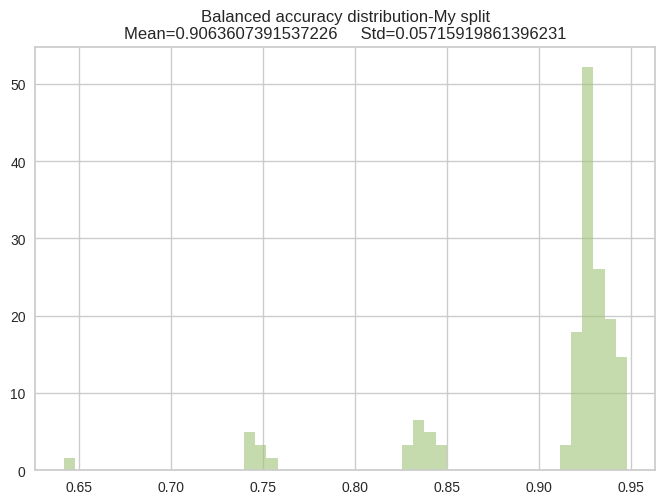

In [12]:
import matplotlib.pyplot as plt
import numpy as np

#plot balanced accuracy distribution
plt.hist(bal_acc_list, bins=50, density=True, alpha=0.6, color='g')
#My split title
plt.title('Balanced accuracy distribution-My split\n'+'Mean='+str(np.mean(bal_acc_list))+'     Std='+str(np.std(bal_acc_list)))
plt.show()